<a href="https://colab.research.google.com/github/sman-1010/SENTIMENT-DETECTION-FROM-FACIAL-EXPRESSIONS/blob/main/Model_on_Video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.cm as cm

#from google.colab import drive

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dropout, Dense, Input, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical, plot_model

from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

In [ ]:
def build_model():
    """
    Create the new model.
  
    This function loads a pre-trained EfficientNetB0 model on Imagenet,
    adds an Input layer at the beggining, and 3 more layers at the end
    (i.e GlobalAveragePooling2D, Dropout, Dense).

    Args:
        No value
   
    Returns:
        model (tensorflow.python.keras.engine.functional.Functional): The compiled model
    """
    
    inputs = Input(shape=(48, 48, 3))
    base_model = ResNet50(include_top=False, weights='imagenet',
                                 input_tensor=inputs)
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(.2, name="top_dropout")(x)
    outputs = Dense(128, activation='relu')(x)
    outputs = Dense(64, activation='relu')(outputs)
    outputs = Dense(6, activation='softmax')(outputs)
    model = Model(inputs, outputs)

    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Create an object of the model
model = build_model()

94781440/94765736 [==============================] - 0s 0us/step


In [ ]:
# model.load_weights('/content/drive/MyDrive/CENG562_Dataset/ins_olsun_large_dataset_ResNet50_128_64.best.hd5f')
model.load_weights('/content/modeltoweb.h5')

# Detect and Crop Face

In [ ]:
# #opencv path

opencv_home = cv2.__file__
folders = opencv_home.split(os.path.sep)[0:-1]

path = folders[0]
for folder in folders[1:]:
	path = path + "/" + folder

face_detector_path = path+"/data/haarcascade_frontalface_default.xml"
eye_detector_path = path+"/data/haarcascade_eye.xml"
nose_detector_path = path+"/data/haarcascade_mcs_nose.xml"

if os.path.isfile(face_detector_path) != True:
	raise ValueError("Confirm that opencv is installed on your environment! Expected path ",detector_path," violated.")

face_detector = cv2.CascadeClassifier(face_detector_path)
#------------------------
def detectFace(img):
	faces = face_detector.detectMultiScale(img, 1.3, 5)
	#print("found faces: ", len(faces))

	if len(faces) > 0:
		face = faces[0]
		face_x, face_y, face_w, face_h = face
		img = img[int(face_y):int(face_y+face_h), int(face_x):int(face_x+face_w)]
		img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
		
		return img, img_gray
	else:
		img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
		return img, img_gray
		#raise ValueError("No face found in the passed image ")
#------------------------


## Read a Video Without Cropping

In [ ]:
vidcap = cv2.VideoCapture('happy_trimmed2.mp4')   ### Enter Video Path here
success,image = vidcap.read()
count = 0
results = []

while success:
  resized = cv2.resize(image, (48,48), interpolation = cv2.INTER_AREA)
  img_batch = np.expand_dims(resized, axis=0)
  img_preprocessed = preprocess_input(img_batch)
  prediction = model.predict(img_preprocessed)
  results.append(prediction[0])
  # print(count,prediction)
  success,image = vidcap.read()
  count += 1

0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral

## Tensorflow JS


In [ ]:
!pip install tensorflowjs

In [ ]:
# model.save("modeltoweb.h5")

In [ ]:
!tensorflowjs_converter --input_format keras '/content/modeltoweb.h5' '/content/drive/MyDrive/CENG562_Dataset/modeltoweb'
# /content/drive/MyDrive/CENG562_Dataset/ins_olsun_large_dataset_ResNet50_128_64.best.h5

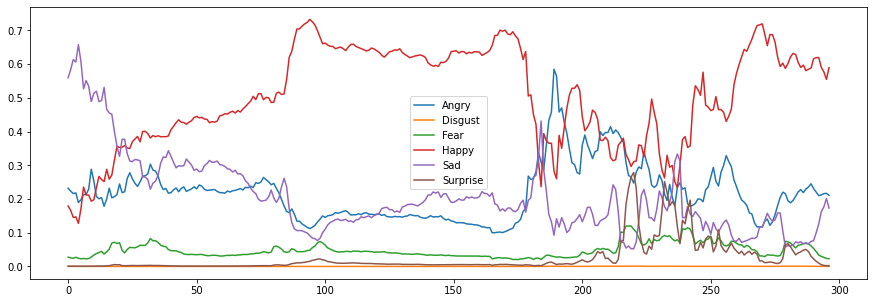

In [ ]:
plt.rcParams['figure.figsize'] = [15, 5]
plt.plot(list(range(297)),results)
plt.legend(['Angry', 'Disgust','Fear','Happy',"Sad",'Surprise','Neutral'])

## Read a Video With Cropping

In [ ]:
vidcap = cv2.VideoCapture('happy_trimmed2.mp4')
success,image = vidcap.read()
count = 0
results = []

while success:
  # cv2.imwrite("frame%d.jpg" % count, image)     # save frame as JPEG file  
  # print(count,image.shape)
  cropped, gray_img = detectFace(image)
  resized = cv2.resize(cropped, (48,48), interpolation = cv2.INTER_AREA)
  img_batch = np.expand_dims(resized, axis=0)
  img_preprocessed = preprocess_input(img_batch)
  prediction = model.predict(img_preprocessed)
  results.append(prediction[0])
  # print(count,prediction)
  success,image = vidcap.read()
  # print('Read a new frame: ', success)
  count += 1

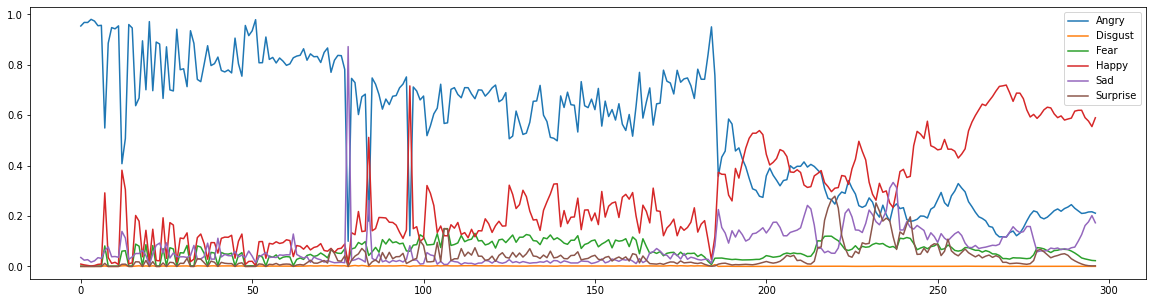

In [ ]:
plt.rcParams['figure.figsize'] = [20, 5]
plt.plot(list(range(count)),results)
plt.legend(['Angry', 'Disgust','Fear','Happy',"Sad",'Surprise','Neutral'])

In [ ]:
import pickle

In [ ]:
# with open("test", "wb") as fp:   #Pickling
#   pickle.dump(results, fp)

## Test below for debugging:

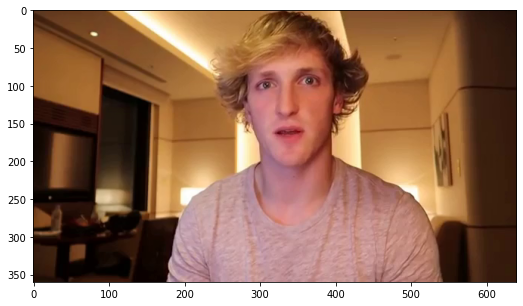

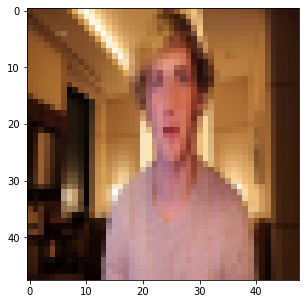

In [ ]:
vidcap = cv2.VideoCapture('cut_lp.mp4')
success,image = vidcap.read()
plt.imshow(image[:, :, ::-1])
plt.show()
resized = cv2.resize(image, (48,48), interpolation = cv2.INTER_AREA)
plt.imshow(resized[:, :, ::-1])
plt.show()

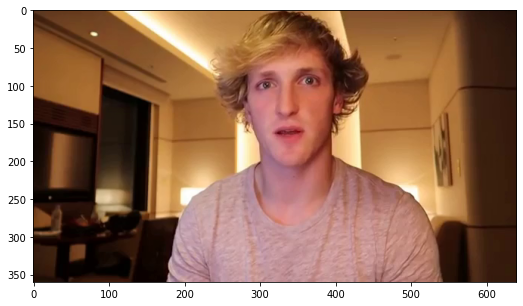

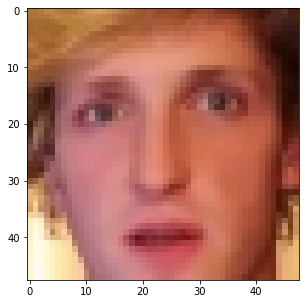

In [ ]:
vidcap = cv2.VideoCapture('cut_lp.mp4')
success,image = vidcap.read()
plt.imshow(image[:, :, ::-1])
plt.show()
cropped, gray_img = detectFace(image)
resized = cv2.resize(cropped, (48,48), interpolation = cv2.INTER_AREA)
plt.imshow(resized[:, :, ::-1])
plt.show()

## Save video as cropped

In [ ]:
vidcap = cv2.VideoCapture('happy_trimmed2.mp4')
success,image = vidcap.read()
count = 0
results = []
cropvid=[]

# choose codec according to format needed
fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
video = cv2.VideoWriter('video.avi', fourcc, 25, (48, 48))

while success:
  # cv2.imwrite("frame%d.jpg" % count, image)     # save frame as JPEG file  
  # print(count,image.shape)
  cropped, gray_img = detectFace(image)
  resized = cv2.resize(cropped, (48,48), interpolation = cv2.INTER_AREA)
  video.write(resized)
  img_batch = np.expand_dims(resized, axis=0)
  img_preprocessed = preprocess_input(img_batch)
  prediction = model.predict(img_preprocessed)
  results.append(prediction[0])
  # print(count,prediction)
  success,image = vidcap.read()
  # print('Read a new frame: ', success)
  count += 1

video.release()

In [ ]:
!ls

drive  happy_trimmed2.mp4  happy_trimmed.mp4  sample_data  test
